# The WARP loss
`lightfm` implements two learning schedules: adagrad and adadelta. Neither is clearly superior, and, like other hyperparameter choices, the best learning schedule will differ based on the problem at hand.

This example tries both at the Movielens 100k dataset.

## Preliminaries
Let's first get the data and define the evaluations functions.

In [1]:
import time

import numpy as np

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

## Experiment
To evaluate the performance of both learning schedules, let's create two models and run each for a number of epochs, measuring the ROC AUC on the test set at the end of each epoch.

In [6]:
alpha = 1e-05
epochs = 35
num_components = 30

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

It looks like the adadelta gets to a better result at the beginning of training. However, as we keep running more epochs adagrad wins out, converging to a better final solution.

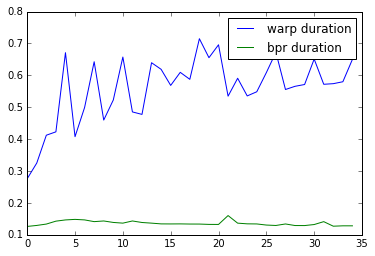

In [7]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['warp duration', 'bpr duration'], loc='upper right')
plt.show()

We can try the same for the k-OS loss.

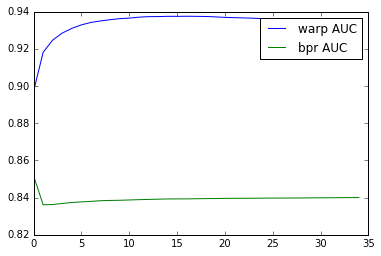

In [8]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['warp AUC', 'bpr AUC'], loc='upper right')
plt.show()